# Manifold GP Supervised Learning via Precision Matrix on 1D Manifold

## Preamble

This notebook provides an example of how to perform Gaussian Process Regression on a 1D manifold. In this example we consider a supervised learning scenario, namely the number of labeled data points is equivalent to the number of the sampled points from the underlying manifold.

In [1]:
import torch
import gpytorch
import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from importlib.resources import files

from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP
from manifold_gp.models.vanilla_gp import VanillaGP
from manifold_gp.utils.mesh_helper import groundtruth_from_samples
from manifold_gp.utils.file_read import get_data
from gpytorch.priors import NormalPrior, GammaPrior

## Dataset Preprocessing

### Load

In [2]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth, geodesics = groundtruth_from_samples(vertices,edges)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

num_train = 100
num_test = 1000
normalize_features = False
normalize_labels = True

### Trainset & Testset

In [3]:
torch.manual_seed(1337)
rand_idx = torch.randperm(m)
train_idx = rand_idx[:num_train]
train_x, train_y = sampled_x[train_idx, :], sampled_y[train_idx]

noise_train_x = 0.0
train_x += noise_train_x * torch.randn(num_train, n)
noise_train_y = 0.01
train_y += noise_train_y * torch.randn(num_train)

test_idx = rand_idx[num_train:num_train+num_test]
test_x, test_y = sampled_x[test_idx, :], sampled_y[test_idx]

noise_test_x = 0.0
test_x += noise_test_x * torch.randn(num_test, n)
noise_test_y = 0.0
test_y += noise_test_y * torch.randn(num_test)

if normalize_features:
    mu_x, std_x = train_x.mean(dim=-2, keepdim=True), train_x.std(dim=-2, keepdim=True) + 1e-6
    sampled_x.sub_(mu_x).div_(std_x)
    train_x.sub_(mu_x).div_(std_x)
    test_x.sub_(mu_x).div_(std_x)
    
if normalize_labels:
    mu_y, std_y = train_y.mean(), train_y.std()
    train_y.sub_(mu_y).div_(std_y)
    test_y.sub_(mu_y).div_(std_y)
    sampled_y.sub_(mu_y).div_(std_y)

### Hyperparameters Priors

In [4]:
import scipy.spatial as ss
neighbors = 10
kd_tree = ss.KDTree(vertices)
v = np.sort(kd_tree.query(vertices, k=neighbors+1)[0][:, 1:].ravel())
percentile_99 = int(np.round(v.shape[0]*0.99))
gamma_rate = 100.0/np.std(v)
gamma_concentration = gamma_rate * v[percentile_99] + 1

### Move Data to Device

In [5]:
sampled_x, sampled_y = sampled_x.contiguous(), sampled_y.contiguous()
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
sampled_x, sampled_y = sampled_x.to(device), sampled_y.to(device)
train_x, train_y = train_x.to(device), train_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

if normalize_features:
    mu_x, std_x = mu_x.to(device), std_x.to(device)

## Vanilla Pre-Trained

## Model

In [7]:
%%capture
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
    noise_prior=None  # NormalPrior(torch.tensor([0.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

kernel = gpytorch.kernels.ScaleKernel(
    RiemannMaternKernel(
        nu=1,
        nodes=train_x,
        neighbors=20,
        operator="randomwalk",
        modes=10,
        ball_scale=3.0,
        support_kernel=gpytorch.kernels.RBFKernel(),
        epsilon_prior=None, # GammaPrior(gamma_concentration, gamma_rate),
        lengthscale_prior=None  # InverseGammaPrior(igamma_concentration, igamma_rate)
    ),
    outputscale_prior=None  # NormalPrior(torch.tensor([1.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

model = RiemannGP(train_x, train_y, likelihood, kernel).to(device)

## Train

In [8]:
%%capture
hypers = {
    'likelihood.noise_covar.noise': 1e-2,
    'covar_module.base_kernel.epsilon': 0.02,
    'covar_module.base_kernel.lengthscale': 0.5,
    'covar_module.outputscale': 1.0,
    'covar_module.base_kernel.support_kernel.lengthscale': 1.0,
}
model.initialize(**hypers)

In [9]:
model.manifold_informed_train(lr=1e-1, iter=100, norm_step_size=50, verbose=True)

Iter: 0, LR: 0.100, Loss: 24866128.000, NoiseVar: 0.010, SignalVar: 1.032, Lengthscale: 0.500, Epsilon: 0.020
Iter: 1, LR: 0.100, Loss: 12317375.000, NoiseVar: 0.009, SignalVar: 1.097, Lengthscale: 0.541, Epsilon: 0.022
Iter: 2, LR: 0.100, Loss: 6032904.000, NoiseVar: 0.008, SignalVar: 1.160, Lengthscale: 0.581, Epsilon: 0.024
Iter: 3, LR: 0.100, Loss: 3025856.500, NoiseVar: 0.008, SignalVar: 1.218, Lengthscale: 0.619, Epsilon: 0.027
Iter: 4, LR: 0.100, Loss: 1583109.375, NoiseVar: 0.007, SignalVar: 1.270, Lengthscale: 0.655, Epsilon: 0.029
Iter: 5, LR: 0.100, Loss: 871129.438, NoiseVar: 0.007, SignalVar: 1.317, Lengthscale: 0.688, Epsilon: 0.031
Iter: 6, LR: 0.100, Loss: 505910.344, NoiseVar: 0.006, SignalVar: 1.360, Lengthscale: 0.718, Epsilon: 0.033
Iter: 7, LR: 0.100, Loss: 310363.562, NoiseVar: 0.006, SignalVar: 1.398, Lengthscale: 0.746, Epsilon: 0.035
Iter: 8, LR: 0.100, Loss: 200907.484, NoiseVar: 0.006, SignalVar: 1.432, Lengthscale: 0.771, Epsilon: 0.037
Iter: 9, LR: 0.100, L

Iter: 89, LR: 0.100, Loss: 8056.648, NoiseVar: 0.004, SignalVar: 1.788, Lengthscale: 1.075, Epsilon: 0.061
Iter: 90, LR: 0.100, Loss: 8049.903, NoiseVar: 0.004, SignalVar: 1.788, Lengthscale: 1.075, Epsilon: 0.061
Iter: 91, LR: 0.100, Loss: 8043.197, NoiseVar: 0.004, SignalVar: 1.788, Lengthscale: 1.076, Epsilon: 0.061
Iter: 92, LR: 0.100, Loss: 8036.528, NoiseVar: 0.004, SignalVar: 1.788, Lengthscale: 1.076, Epsilon: 0.061
Iter: 93, LR: 0.100, Loss: 8029.875, NoiseVar: 0.004, SignalVar: 1.788, Lengthscale: 1.077, Epsilon: 0.061
Iter: 94, LR: 0.100, Loss: 8023.251, NoiseVar: 0.004, SignalVar: 1.789, Lengthscale: 1.077, Epsilon: 0.061
Iter: 95, LR: 0.100, Loss: 8016.638, NoiseVar: 0.004, SignalVar: 1.789, Lengthscale: 1.078, Epsilon: 0.061
Iter: 96, LR: 0.100, Loss: 8010.044, NoiseVar: 0.004, SignalVar: 1.789, Lengthscale: 1.078, Epsilon: 0.061
Iter: 97, LR: 0.100, Loss: 8003.465, NoiseVar: 0.004, SignalVar: 1.789, Lengthscale: 1.079, Epsilon: 0.061
Iter: 98, LR: 0.100, Loss: 7996.892, 

## Evaluation

In [11]:
%%capture
likelihood.eval()
model.eval()

## Metrics

In [26]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cg_tolerance(10000):
    preds_test = likelihood(model(test_x))
#     preds_test = likelihood(model_vanilla(test_x))
        
    error = test_y - preds_test.mean
    covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
    inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)
    
    rmse = (error.square().sum()/num_test).sqrt()
    nll = 0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/num_test
    
print("RMSE: ", rmse)
print("NLL: ", nll)

RMSE:  tensor(0.5744, device='cuda:0')
NLL:  tensor(1.0744, device='cuda:0')


## Plot

In [14]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_manifold = model(sampled_x)
    preds_fourier = model_vanilla(sampled_x)
    scale_manifold = kernel.base_kernel.scale_posterior(sampled_x, beta=0.01)
    
    resolution = 100
    x, y = torch.meshgrid(torch.linspace(-1.5, 1.5, resolution), torch.linspace(-1.5, 1.5, resolution), indexing='xy')
    grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
    
    if normalize_features:
        preds_ambient = model(grid_x.sub(mu_x).div(std_x))
        preds_fourier_ambient = model_vanilla(grid_x.sub(mu_x).div(std_x))
        scale_ambient = kernel.base_kernel.scale_posterior(grid_x.sub(mu_x).div(std_x), beta=0.01)
        
        sampled_x.mul_(std_x).add_(mu_x)
        train_x.mul_(std_x).add_(mu_x)
        test_x.mul_(std_x).add_(mu_x)
    else:
        preds_ambient = model(grid_x)
        preds_fourier_ambient = model_vanilla(grid_x)
        scale_ambient = kernel.base_kernel.scale_posterior(grid_x, beta=0.01)
    

### Ground Truth & Posterior Mean

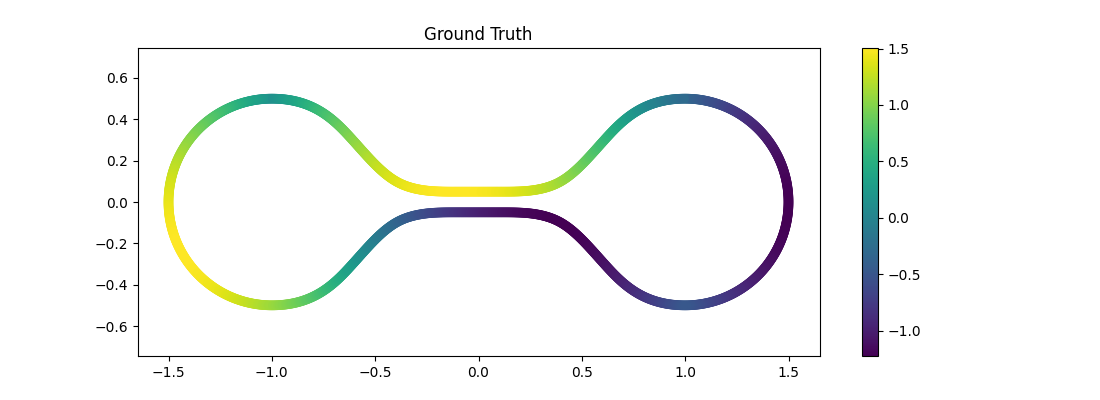

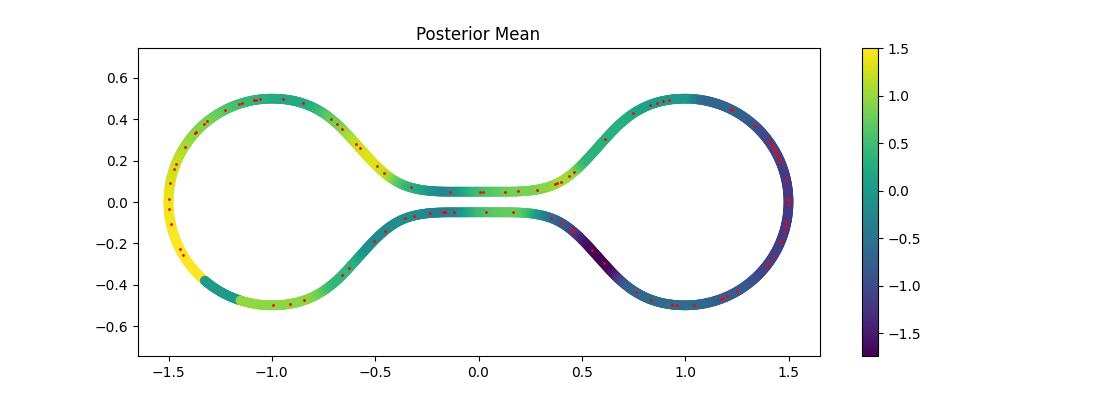

In [15]:
with torch.no_grad():
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=sampled_y.cpu().numpy())  # vmin=-0.5, vmax=0.5
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Ground Truth')
    
    posterior_mean = preds_manifold.mean.cpu().numpy()
#     posterior_mean = preds_fourier.mean.cpu().numpy()
#     posterior_mean = (scale_manifold*preds_manifold.mean + (1-scale_manifold)*preds_fourier.mean).cpu().numpy()
    
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=posterior_mean)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=1.0)
#     ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c='k', s=1.0)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Posterior Mean')

### Kernel Evaluation

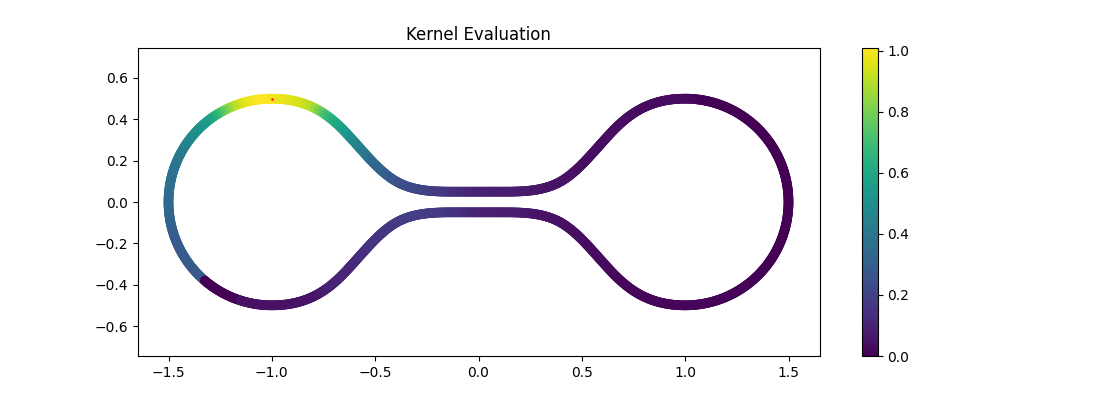

In [16]:
with torch.no_grad():
    k_base = kernel.base_kernel(sampled_x[0, :].unsqueeze(0), sampled_x[0, :].unsqueeze(0)).evaluate()
    kernel_eval_manifold = (kernel.base_kernel(sampled_x[0, :].unsqueeze(0), sampled_x).evaluate()/k_base).squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=kernel_eval_manifold)
    ax.scatter(sampled_x.cpu().numpy()[0, 0], sampled_x.cpu().numpy()[0, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Kernel Evaluation')

### Features

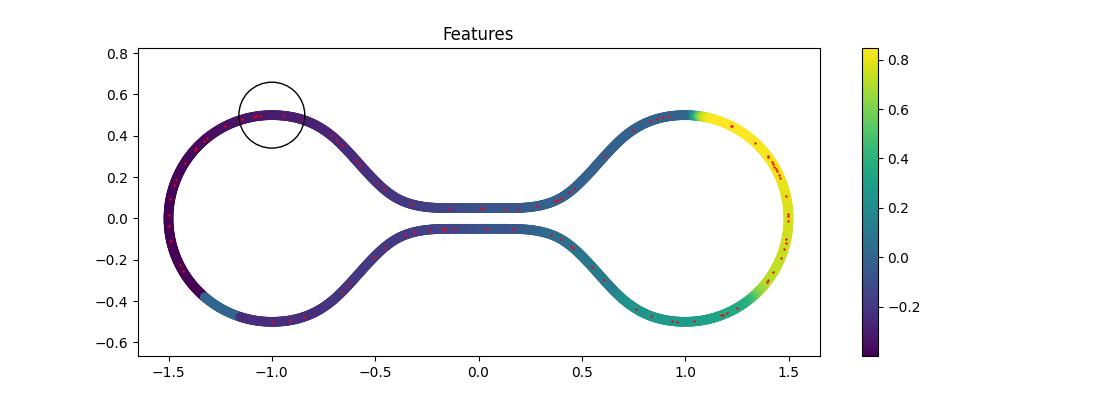

In [17]:
with torch.no_grad():
    c = kernel.base_kernel.ball_scale
    l_features = kernel.base_kernel.features(sampled_x, c=c)[:,1].cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=l_features)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    circle = plt.Circle((sampled_x.cpu().numpy()[0, 0], sampled_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
    ax.add_patch(circle)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Features')

# Prior Standard Deviation

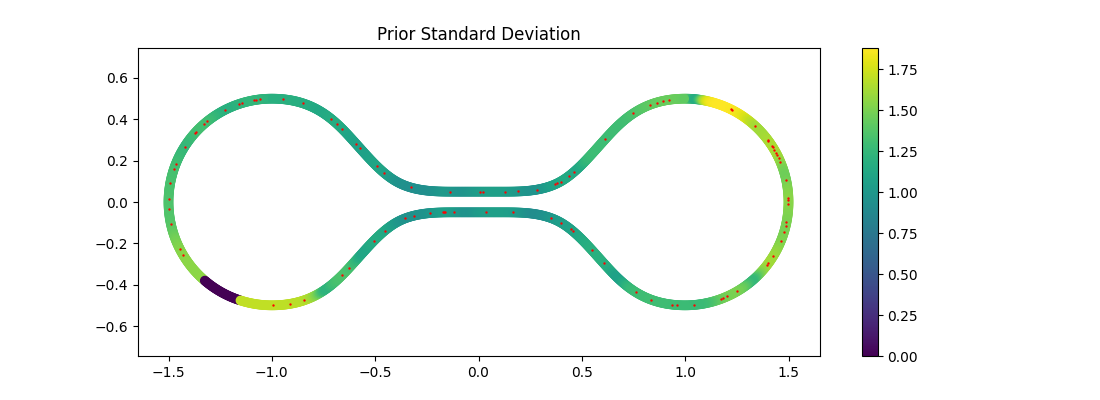

In [27]:
with torch.no_grad():
    prior_std = model.covar_module(sampled_x, sampled_x, diag=True).sqrt()
#     prior_std = model_vanilla.covar_module(sampled_x, sampled_x, diag=True).sqrt()
#     prior_std = (scale_manifold*model.covar_module(sampled_x, sampled_x, diag=True).sqrt() + (1-scale_manifold)*model_vanilla.covar_module(sampled_x, sampled_x, diag=True).sqrt())
    
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=prior_std.cpu().numpy())
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Prior Standard Deviation')

### Posterior Standard Deviation

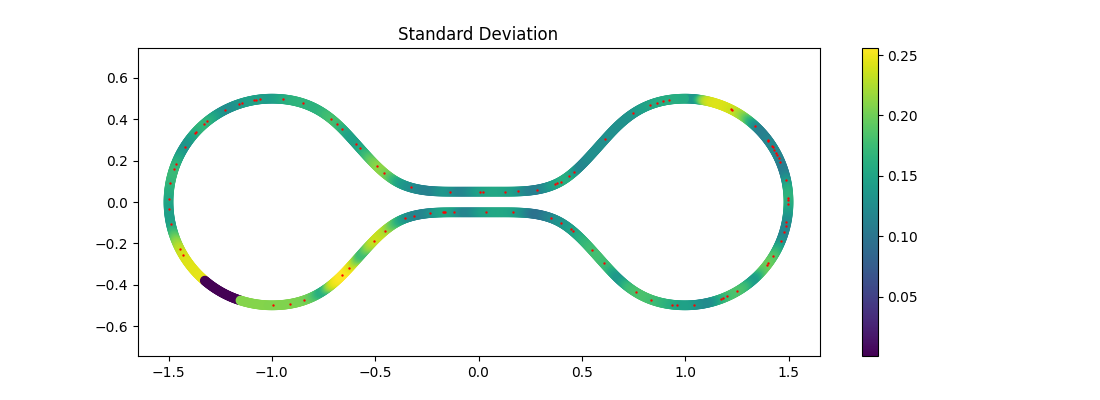

In [28]:
with torch.no_grad():
    posterior_std = preds_manifold.stddev
#     posterior_std = preds_fourier.stddev
#     posterior_std = (scale_manifold*preds_manifold.stddev + (1-scale_manifold)*preds_fourier.stddev)
    
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=posterior_std.cpu().numpy())
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Standard Deviation')

### Ambient Posterior Mean

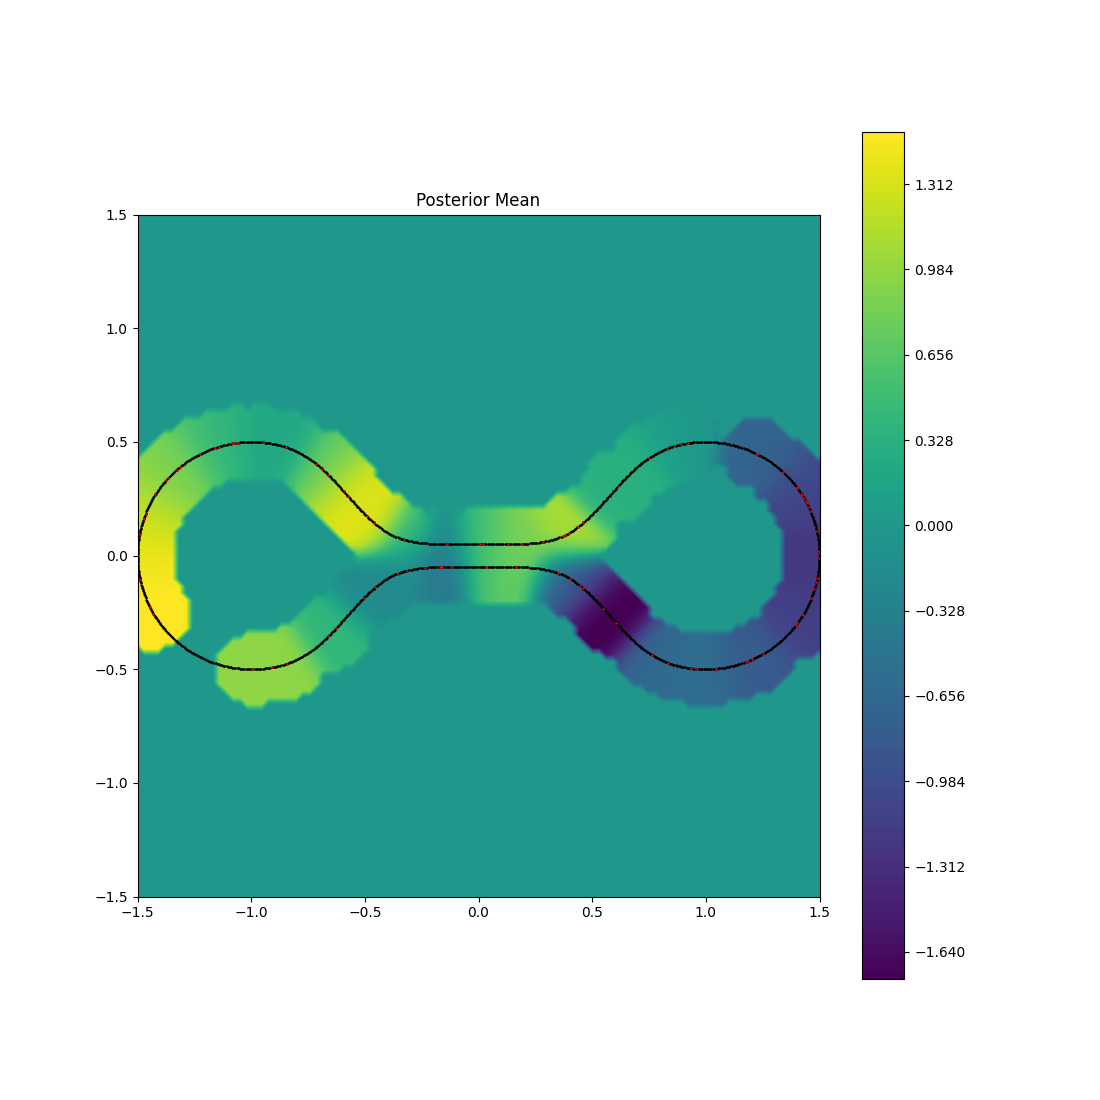

In [29]:
with torch.no_grad():
    posterior_mean_ambient = preds_ambient.mean
#     posterior_mean_ambient = preds_fourier_ambient.mean
#     posterior_mean_ambient = (scale_ambient*preds_ambient.mean + (1-scale_ambient)*preds_fourier_ambient.mean)
    
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_mean_ambient.cpu().numpy().reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_mean_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Posterior Mean')

### Ambient Kernel Evaluation

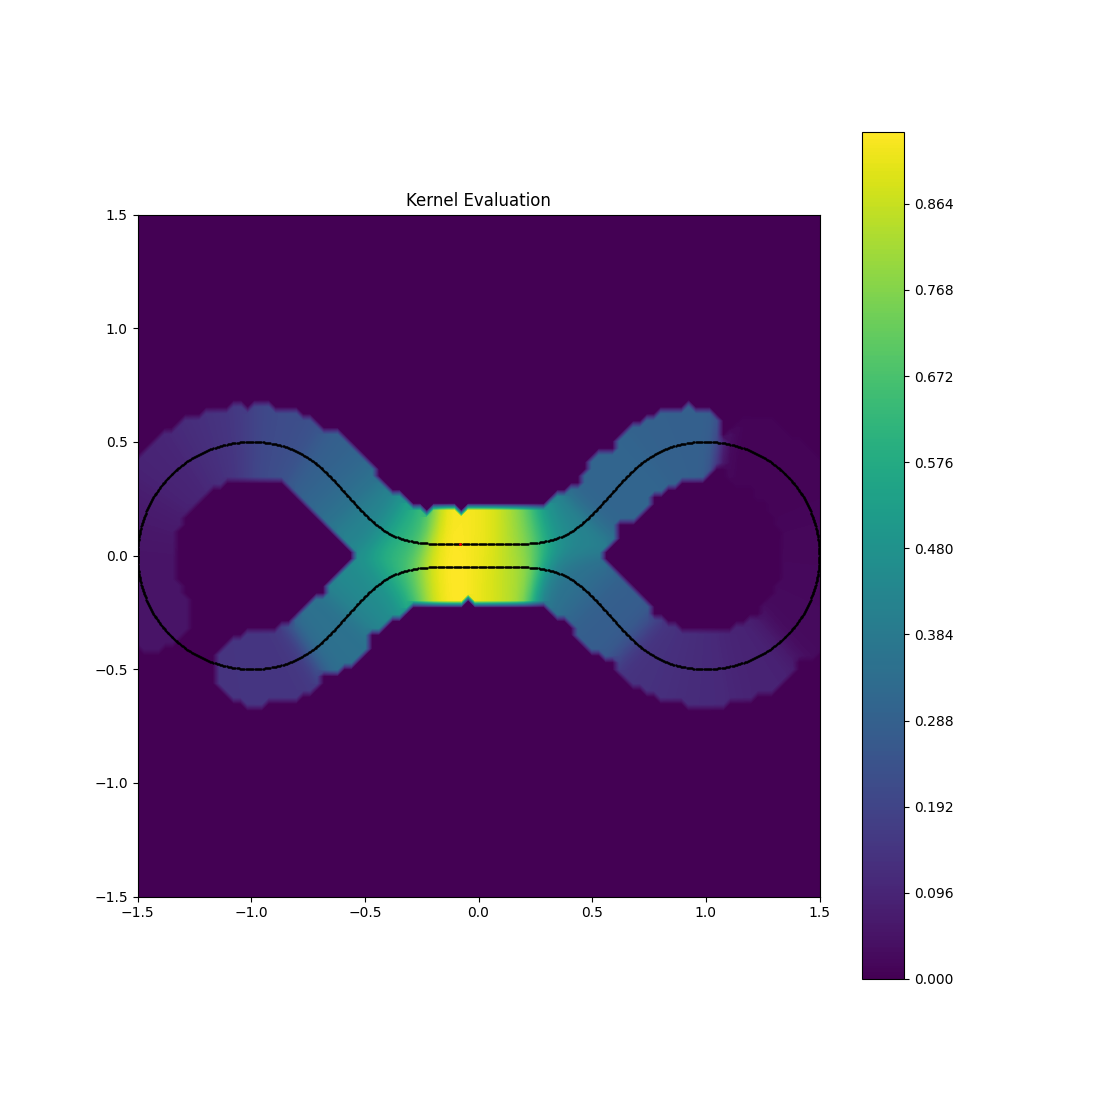

In [30]:
with torch.no_grad():
    kernel_eval_ambient = model.covar_module(sampled_x[848, :].unsqueeze(0), grid_x).evaluate().squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), kernel_eval_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), kernel_eval_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(sampled_x.cpu().numpy()[848, 0], sampled_x.cpu().numpy()[848, 1], c='r', s=1.0)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Kernel Evaluation')

### Ambient Features

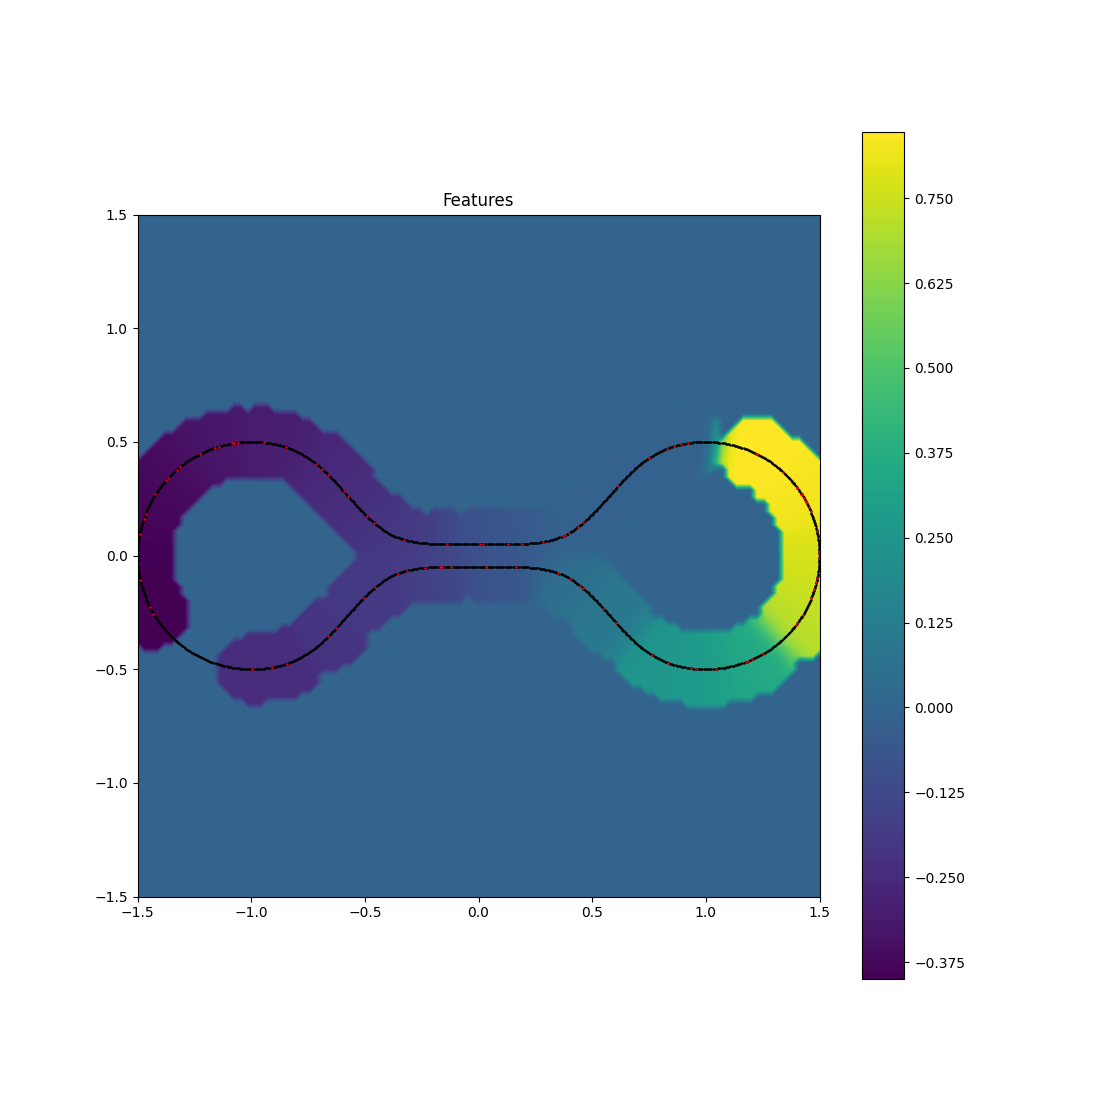

In [31]:
with torch.no_grad():
    c = 3.0
    features_grid = kernel.base_kernel.features(grid_x, c=c)[:,1].cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), features_grid.reshape(resolution, -1), 500)
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    circle = plt.Circle((sampled_x.cpu().numpy()[0, 0], sampled_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
#     ax.add_patch(circle)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Features')

### Ambient Prior Standard Deviation

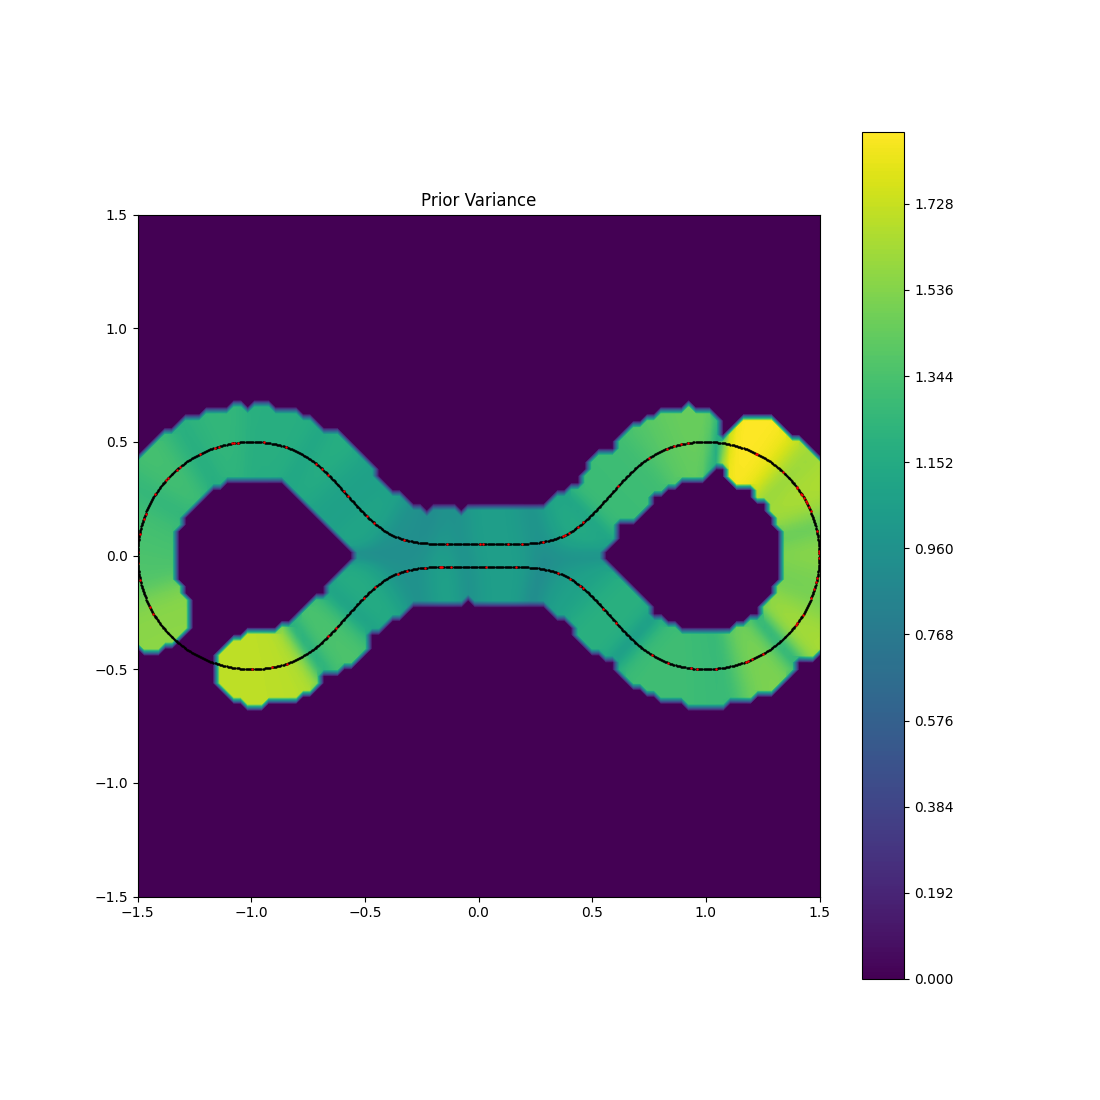

In [32]:
with torch.no_grad():
    prior_std_ambient = model.covar_module(grid_x, grid_x, diag=True).sqrt()
#     prior_std_ambient = model_vanilla.covar_module(grid_x, grid_x, diag=True).sqrt()
#     prior_std_ambient = (scale_ambient*model.covar_module(grid_x, grid_x, diag=True).sqrt() + (1-scale_ambient)*model_vanilla.covar_module(grid_x, grid_x, diag=True).sqrt())
    
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), prior_std_ambient.cpu().numpy().reshape(resolution, -1), 500)
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Prior Variance')

### Ambient Posterior Standard Deviation

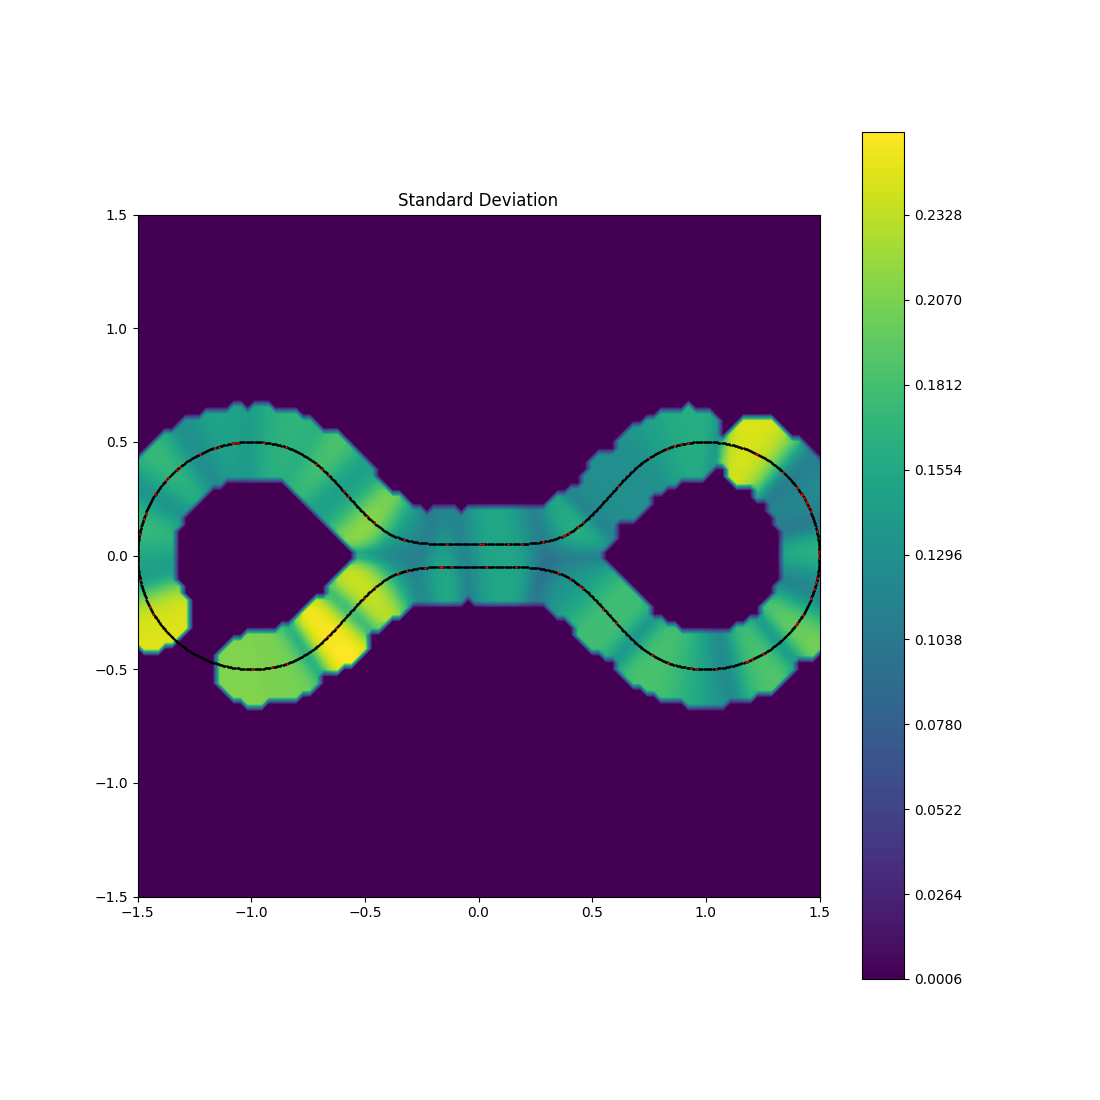

In [34]:
with torch.no_grad():
    posterior_std_ambient = preds_ambient.stddev
#     posterior_std_ambient = preds_fourier_ambient.stddev
#     posterior_std_ambient = (scale_ambient*preds_ambient.stddev + (1-scale_ambient)*preds_fourier_ambient.stddev)

    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_std_ambient.cpu().numpy().reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_std_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Standard Deviation')